#### <a>Objective: To analyze customer reviews and predict customer satisfaction with the reviews.

#### <a>Business Context</a>

Central banks collecting information about customer satisfaction with the services provided by different banks. Also collects the information about the complaints.

Bank users give ratings and write reviews about the services on central bank websites. These reviews and ratings help banks evaluate services provided and take necessary action to improve customer service. While ratings are useful to convey the overall experience, they do not convey the context which led a reviewer to that experience.

If we look at only the rating, it is difficult to guess why the user rated the service as 4 stars. However, after reading the review, it is not difficult to identify that the review talks about good 'service' and 'experience'.

#### <a>Dataset Description</a>

The data is detailed dump of customer reviews /complaints (~500) of different services at different banks.

 Date - Day of the review posted<br>
 Stars - 1-5 rating for the business<br>
 Reviews - Reviews/Complaints by customers<br>
 Bank Name - Name of the Bank of the customer
 
#### <a>Data Source:</a> https://www.kaggle.com/darpan25bajaj/bank-reviewcomplaint-analysis

#### <a> Importing Libraries

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
%matplotlib inline

import inflect

from sklearn.feature_extraction.text import TfidfVectorizer
from textblob import TextBlob

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import string
import re

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.cluster import KMeans

from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn import metrics

from sklearn.linear_model import LogisticRegression
from sklearn.tree import ExtraTreeClassifier
from xgboost import XGBClassifier

#### <a> Loading Dataset

In [2]:
bank_data = pd.read_excel('BankReviews.xlsx')

#### <a>Understanding the Dataset

In [3]:
#View of Dataset
bank_data.head()

,Date,Stars,Reviews,BankName
0,2017-04-10,5,"Great job, Wyndham Capital! Each person was pr...",Wyndham Capital Mortgage
1,2017-02-10,5,Matthew Richardson is professional and helpful...,Wyndham Capital Mortgage
2,2017-08-21,5,We had a past experience with Wyndham Mortgage...,Wyndham Capital Mortgage
3,2017-12-17,5,We have been dealing with Brad Thomka from the...,Wyndham Capital Mortgage
4,2016-05-27,5,I can't express how grateful I am for the supp...,Wyndham Capital Mortgage


In [4]:
#Dataset Information
bank_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 505 entries, 0 to 504
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      505 non-null    datetime64[ns]
 1   Stars     505 non-null    int64         
 2   Reviews   505 non-null    object        
 3   BankName  505 non-null    object        
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 15.9+ KB


In [5]:
#Dropping Date column as it does have any significance
bank_data.drop('Date', axis = 1, inplace = True)

In [6]:
#Removing line breaks
bank_data['Reviews'] = bank_data['Reviews'].apply(lambda x: x.replace("_x000D_\n", ""))
bank_data['Reviews'] = bank_data['Reviews'].apply(lambda x: ' '.join(x.split()))

In [7]:
bank_data['Reviews'].head()

0    Great job, Wyndham Capital! Each person was pr...
1    Matthew Richardson is professional and helpful...
2    We had a past experience with Wyndham Mortgage...
3    We have been dealing with Brad Thomka from the...
4    I can't express how grateful I am for the supp...
Name: Reviews, dtype: object

#### <a>Exploratory Data Analysis

5    410
1     95
Name: Stars, dtype: int64


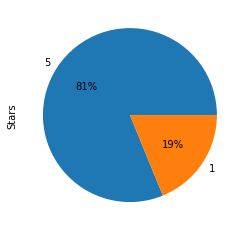

In [8]:
#Count of different Stars rating
print(bank_data.Stars.value_counts())
bank_data.Stars.value_counts().plot(kind = 'pie', autopct='%1.0f%%')
plt.show()

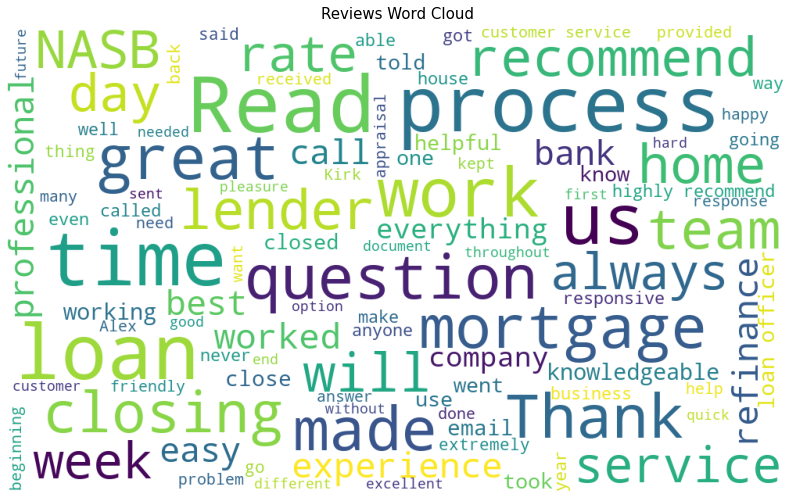

In [9]:
#Reviews Word Cloud
wd = WordCloud(
                width=1000, height=600,
                max_words = 100, random_state = 123,
                background_color = 'white', max_font_size = 100 
               ).generate(' '.join(bank_data['Reviews'].astype(str)).replace('_x000D_\n', ''))

plt.figure(figsize = (14,10))
plt.imshow(wd)
plt.title('Reviews Word Cloud', fontsize = 15)
plt.axis('off')
plt.show()

### <a>Text Cleaning 

#### <a>Converting Text to Lowercase

In [10]:
bank_data['Reviews'] = bank_data['Reviews'].astype(str)
bank_data['Reviews'] = bank_data['Reviews'].apply(lambda x : x.lower())

In [11]:
bank_data['Reviews'].head()

0    great job, wyndham capital! each person was pr...
1    matthew richardson is professional and helpful...
2    we had a past experience with wyndham mortgage...
3    we have been dealing with brad thomka from the...
4    i can't express how grateful i am for the supp...
Name: Reviews, dtype: object

#### <a>Converting Numbers to words

In [12]:
#UDF for converting numbers to words
eng = inflect.engine()

def num_convert(text):
    
    word_list = text.split()
    new_text = []
    
    for i in word_list:
        if i.isdigit():
            num =  eng.number_to_words(i)
            new_text.append(num)
        
        else:
            new_text.append(i)
    
    word_list = ' '.join(new_text)
    return word_list        

In [13]:
bank_data['Reviews'] = bank_data['Reviews'].apply(num_convert)

In [14]:
bank_data['Reviews'].head()

0    great job, wyndham capital! each person was pr...
1    matthew richardson is professional and helpful...
2    we had a past experience with wyndham mortgage...
3    we have been dealing with brad thomka from the...
4    i can't express how grateful i am for the supp...
Name: Reviews, dtype: object

#### <a>Removing Punctuations

In [15]:
bank_data['Reviews'] = bank_data['Reviews'].apply(lambda x : x.translate(str.maketrans('','', string.punctuation)))

In [16]:
bank_data['Reviews'].head()

0    great job wyndham capital each person was prof...
1    matthew richardson is professional and helpful...
2    we had a past experience with wyndham mortgage...
3    we have been dealing with brad thomka from the...
4    i cant express how grateful i am for the suppo...
Name: Reviews, dtype: object

#### <a> Removing Extra Spaces

In [17]:
bank_data['Reviews'] = bank_data['Reviews'].apply(lambda x : ' '.join(x.split()))

In [18]:
bank_data['Reviews'].head()

0    great job wyndham capital each person was prof...
1    matthew richardson is professional and helpful...
2    we had a past experience with wyndham mortgage...
3    we have been dealing with brad thomka from the...
4    i cant express how grateful i am for the suppo...
Name: Reviews, dtype: object

#### <a> Removing StopWords

In [19]:
bank_data['Reviews'] = bank_data['Reviews'].apply(lambda x : ' '.join([i for i in x.split() if i not in set(stopwords.words('English'))]))

In [20]:
bank_data['Reviews'].head()

0    great job wyndham capital person professional ...
1    matthew richardson professional helpful helped...
2    past experience wyndham mortgage would without...
3    dealing brad thomka beginning started stressfu...
4    cant express grateful support zach provided fa...
Name: Reviews, dtype: object

#### <a>Lemmitization

In [21]:
lemm = WordNetLemmatizer()
bank_data['Reviews'] = bank_data['Reviews'].apply(lambda x: ' '.join([lemm.lemmatize(word, pos = 'v') for word in x.split()]))

In [22]:
bank_data['Reviews'].head()

0    great job wyndham capital person professional ...
1    matthew richardson professional helpful help u...
2    past experience wyndham mortgage would without...
3    deal brad thomka begin start stressful time us...
4    cant express grateful support zach provide fam...
Name: Reviews, dtype: object

### <a> WordCloud of Positive and Negative Words

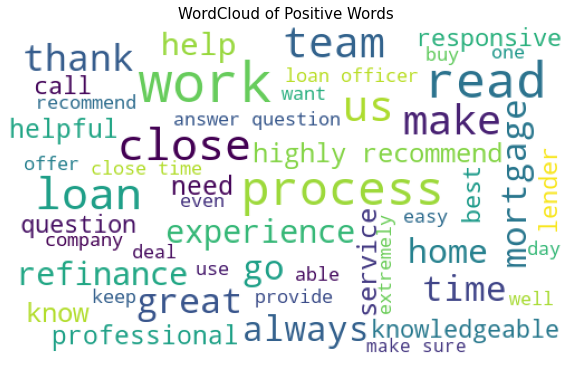

In [23]:
#WordCloud of Positive Words
wd = WordCloud(
                width=500, height=300,
                max_words = 50, random_state = 123,
                background_color = 'white', max_font_size = 50
               ).generate(' '.join(bank_data.loc[bank_data['Stars'] == 5,'Reviews'].astype(str)))

plt.figure(figsize = (10,8))
plt.imshow(wd)
plt.title('WordCloud of Positive Words', fontsize = 15)
plt.axis('off')
plt.show()

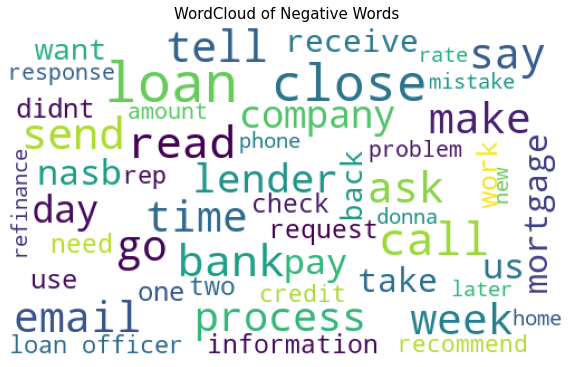

In [24]:
#WordCloud of Negative Words
wd = WordCloud(
                width=500, height=300,
                max_words = 50, random_state = 123,
                background_color = 'white', max_font_size = 50
               ).generate(' '.join(bank_data.loc[bank_data['Stars'] == 1,'Reviews'].astype(str)))

plt.figure(figsize = (10,8))
plt.imshow(wd)
plt.title('WordCloud of Negative Words', fontsize = 15)
plt.axis('off')
plt.show()

### <a> Sentiment Analysis

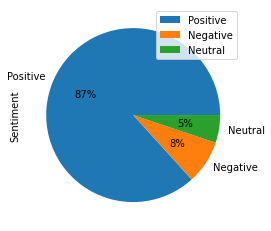

In [25]:
sa = pd.DataFrame()

#Getting Polarity of Reviews
sa['Polarity'] = bank_data['Reviews'].apply(lambda x: TextBlob(x).sentiment.polarity)

#Getting Sentiments of Reviews from Polarity
sa['Sentiment'] = np.where(sa['Polarity'] > 0, 'Positive',
                           np.where(sa['Polarity'] < 0, 'Negative', 'Neutral'))

#Pie Plot of Reviews Sentiment
sa['Sentiment'].value_counts().plot(kind = 'pie', autopct= '%1.0f%%')
plt.legend()
plt.show()

In [26]:
#Creating Tf-IDF Model
tf = TfidfVectorizer(min_df = 0.05, max_df = 0.95,
                stop_words = stopwords.words('english'))
tf.fit(bank_data['Reviews'])
X_tf = tf.transform(bank_data['Reviews'])

### <a>Identifying Key Themes

In [27]:
#Running KMeans model to get Key Topics
km = KMeans(n_clusters = 6, random_state = 123)
res = km.fit(X_tf)

In [28]:
#Getting Cluster Centers
cc = res.cluster_centers_

In [29]:
#Sorting Centers
sort_cc = [res.cluster_centers_[i].argsort() for i in range(0, len(cc))]

In [30]:
#Getting Features Names from the Tf-Idf Vectorizer
fnm = np.array(tf.get_feature_names())

In [31]:
#Getting Topics
words = []
for i in range(len(cc)):
    words.append(fnm[sort_cc[i][-10:]])
    print('\n Cluster %d: '%i, fnm[sort_cc[i][-10:]])


 Cluster 0:  ['begin' 'loan' 'best' 'help' 'care' 'thank' 'get' 'work' 'able' 'us']

 Cluster 1:  ['helpful' 'make' 'easy' 'work' 'loan' 'recommend' 'question' 'help'
 'quick' 'process']

 Cluster 2:  ['go' 'make' 'time' 'say' 'email' 'get' 'would' 'close' 'loan' 'call']

 Cluster 3:  ['work' 'recommend' 'rate' 'provide' 'use' 'mortgage' 'loan' 'close'
 'team' 'process']

 Cluster 4:  ['process' 'customer' 'always' 'pleasure' 'get' 'professional' 'service'
 'responsive' 'work' 'great']

 Cluster 5:  ['first' 'recommend' 'easy' 'close' 'time' 'work' 'experience' 'purchase'
 'home' 'nasb']


### <a>Prediction Model - 
<h4> <a>For predicting Star Rating

In [32]:
#Defining X and Y
X = X_tf
Y = bank_data['Stars']

In [33]:
#Splitting Dataset into train and test dataset
train_x, test_x, train_y, test_y = train_test_split(X, Y, test_size = 0.2, random_state = 123)

#### <a>Logistic Regression Model

In [34]:
#Executing Model
lr = LogisticRegression(n_jobs = -1).fit(train_x, train_y)

#Making prediction on train and test data
train_pred_lr = lr.predict(train_x)
test_pred_lr = lr.predict(test_x)

#Calculating log loss
log_lr = metrics.log_loss(test_y, lr.predict_proba(test_x))

In [35]:
#Evaluating performance
print("Model Performance")
print("Train Dataset")
print("Accuracy : ", metrics.accuracy_score(train_y, train_pred_lr))
print("AUC      : ", metrics.roc_auc_score(train_y, lr.predict_proba(train_x)[:,1]))
print("")
print("Test Dataset")
acc_score_lr = metrics.accuracy_score(test_y, test_pred_lr)
print("Accuracy : ", acc_score_lr)
auc_lr = metrics.roc_auc_score(test_y, lr.predict_proba(test_x)[:,1])
print("AUC      : ", auc_lr)
print("Log Loss : ", log_lr )

Model Performance
Train Dataset
Accuracy :  0.9257425742574258
AUC      :  0.986139243019977

Test Dataset
Accuracy :  0.900990099009901
AUC      :  0.9718875502008031
Log Loss :  0.24620590588110064


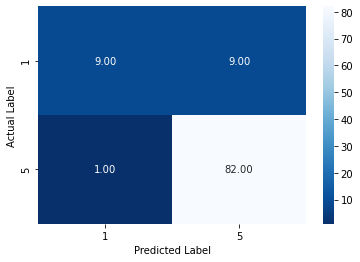

In [36]:
#Confusion Matrix
confusion_matrix = metrics.confusion_matrix(test_y, test_pred_lr, labels = [1,5])
sns.heatmap(confusion_matrix, annot = True, fmt = '.2f',
            xticklabels = ['1','5'],
            yticklabels = ['1','5'],
            cmap = 'Blues_r'    
           )
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.show()

In [37]:
#Classification metrics scores of the model
print(metrics.classification_report(test_y, test_pred_lr))

              precision    recall  f1-score   support

           1       0.90      0.50      0.64        18
           5       0.90      0.99      0.94        83

    accuracy                           0.90       101
   macro avg       0.90      0.74      0.79       101
weighted avg       0.90      0.90      0.89       101



#### <a>Extra Tree Model

In [38]:
#Using GridSearchCV to get best fit parameters
pm = {
      'max_depth' : [10],
       'splitter' : ['best'],
      'max_features' : [4]
     }

gscv_et = GridSearchCV(estimator = ExtraTreeClassifier(random_state = 123), 
                    param_grid = pm,
                    cv = 10,
                    scoring = 'roc_auc',
                    n_jobs = -1).fit(train_x, train_y)

In [39]:
#Using best fit parameters to fit the model
et = gscv_et.best_estimator_

#Making prediction on train and test data
train_pred_et = et.predict(train_x)
test_pred_et = et.predict(test_x)

#Calculating log loss
log_et = metrics.log_loss(test_y, et.predict_proba(test_x))

In [40]:
#Evaluating performance
print("Model Performance")
print("Train Dataset")
print("Accuracy : ", metrics.accuracy_score(train_y, train_pred_et))
print("AUC      : ", metrics.roc_auc_score(train_y, et.predict_proba(train_x)[:,1]))
print("")
print("Test Dataset")
acc_score_et = metrics.accuracy_score(test_y, test_pred_et)
print("Accuracy : ", acc_score_et)
auc_et = metrics.roc_auc_score(test_y, et.predict_proba(test_x)[:,1])
print("AUC      : ", auc_et)
print("Log Loss : ", log_et)

Model Performance
Train Dataset
Accuracy :  0.9504950495049505
AUC      :  0.9531554072838476

Test Dataset
Accuracy :  0.8811881188118812
AUC      :  0.8627844712182061
Log Loss :  2.193419150490504


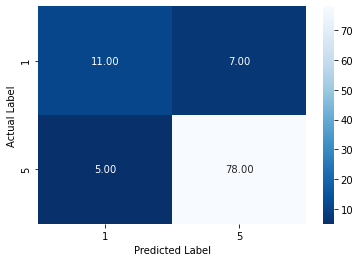

In [41]:
#Confusion Matrix
confusion_matrix = metrics.confusion_matrix(test_y, test_pred_et, labels = [1,5])
sns.heatmap(confusion_matrix, annot = True, fmt = '.2f',
            xticklabels = ['1','5'],
            yticklabels = ['1','5'],
            cmap = 'Blues_r'    
           )
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.show()

In [42]:
#Classification metrics scores of the model
print(metrics.classification_report(test_y, test_pred_et))

              precision    recall  f1-score   support

           1       0.69      0.61      0.65        18
           5       0.92      0.94      0.93        83

    accuracy                           0.88       101
   macro avg       0.80      0.78      0.79       101
weighted avg       0.88      0.88      0.88       101



#### <a>XG Boost Model

In [43]:
#Using GridSearchCV to get best fit parameters
pm = {
          'n_estimators' : [100],
          'learning_rate': [0.1]
     }

gscv_xg = GridSearchCV(estimator = XGBClassifier(random_state = 123), 
                    param_grid = pm,
                    cv = 10,
                    scoring = 'roc_auc',
                    n_jobs = -1).fit(train_x, train_y)

C:\Users\test123\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:43:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [44]:
#Using best fit parameters to fit the model
xg = gscv_xg.best_estimator_

#Making prediction on train and test data
train_pred_xg = xg.predict(train_x)
test_pred_xg = xg.predict(test_x)

#Calculating log loss
log_xg = metrics.log_loss(test_y, xg.predict_proba(test_x))

In [45]:
#Evaluating performance
print("Model Performance")
print("Train Dataset")
print("Accuracy : ", metrics.accuracy_score(train_y, train_pred_xg))
print("AUC      : ", metrics.roc_auc_score(train_y, xg.predict_proba(train_x)[:,1]))
print("")
print("Test Dataset")
acc_score_xg = metrics.accuracy_score(test_y, test_pred_xg)
print("Accuracy : ", acc_score_xg)
auc_xg = metrics.roc_auc_score(test_y, xg.predict_proba(test_x)[:,1])
print("AUC      : ", auc_xg)
print("Log Loss : ", log_xg)

Model Performance
Train Dataset
Accuracy :  0.9925742574257426
AUC      :  0.9993248341872196

Test Dataset
Accuracy :  0.9108910891089109
AUC      :  0.9725568942436412
Log Loss :  0.20866410694855017


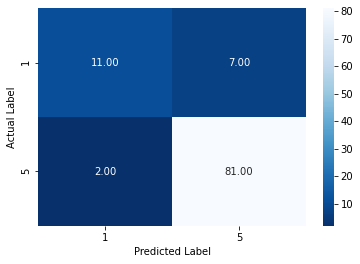

In [46]:
#Confusion Matrix
confusion_matrix = metrics.confusion_matrix(test_y, test_pred_xg, labels = [1,5])
sns.heatmap(confusion_matrix, annot = True, fmt = '.2f',
            xticklabels = ['1','5'],
            yticklabels = ['1','5'],
            cmap = 'Blues_r'    
           )
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.show()

In [47]:
#Classification metrics scores of the model
print(metrics.classification_report(test_y, test_pred_xg))

              precision    recall  f1-score   support

           1       0.85      0.61      0.71        18
           5       0.92      0.98      0.95        83

    accuracy                           0.91       101
   macro avg       0.88      0.79      0.83       101
weighted avg       0.91      0.91      0.91       101



#### <a>Comparing metrics of each model

In [48]:
#Getting accuracy and log loss for each model
metric_data = pd.DataFrame({'Classifiers' : ['LogisticRegression', 'ExtraTreeClassifier', 'XGBClassifier'],
                        'Accuracy %' : [acc_score_lr, acc_score_et, acc_score_xg],
                        'ROC_AUC_Score %' : [auc_lr, auc_et, auc_xg],    
                        'Log_Loss' : [log_lr, log_et, log_xg]})

In [49]:
metric_data[['Accuracy %','ROC_AUC_Score %']] = metric_data[['Accuracy %', 'ROC_AUC_Score %']].applymap(lambda x : round((x*100),3))

In [50]:
#metric_data.to_excel(output, 'Binomial Metric Data')
metric_data

,Classifiers,Accuracy %,ROC_AUC_Score %,Log_Loss
0,LogisticRegression,90.099,97.189,0.246206
1,ExtraTreeClassifier,88.119,86.278,2.193419
2,XGBClassifier,91.089,97.256,0.208664


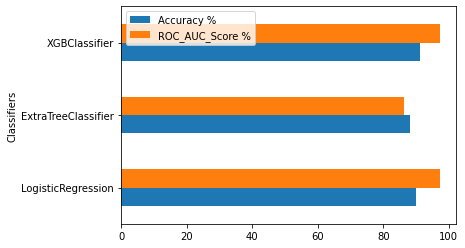

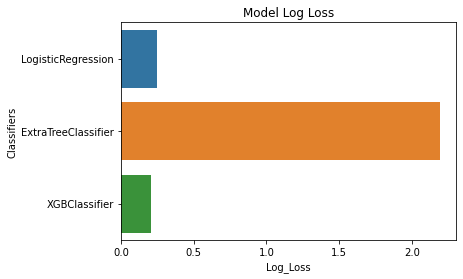

In [51]:
#Visualizing each model's accuracy and log loss metric
metric_data.plot(x = 'Classifiers', y = ['Accuracy %','ROC_AUC_Score %'], kind = 'barh')
plt.legend(loc = 2)
plt.show()

sns.barplot(data = metric_data, x = metric_data['Log_Loss'], y = metric_data.Classifiers)
plt.title('Model Log Loss')
plt.show()

From above plots, XG Boost Model performs best. It has highest accuracy and ROC AUC Score and lowest log loss.

#### <a> Making Final Prediction 

In [52]:
#Making final prediction
bank_data['Predicted Stars'] = xg.predict(X)

In [53]:
bank_data.head()

,Stars,Reviews,BankName,Predicted Stars
0,5,great job wyndham capital person professional ...,Wyndham Capital Mortgage,5
1,5,matthew richardson professional helpful help u...,Wyndham Capital Mortgage,5
2,5,past experience wyndham mortgage would without...,Wyndham Capital Mortgage,5
3,5,deal brad thomka begin start stressful time us...,Wyndham Capital Mortgage,5
4,5,cant express grateful support zach provide fam...,Wyndham Capital Mortgage,5
